# Environmental Sound Classification using CNN and Mel-Spectrograms




Bu notebook, **UrbanSound8K** veri seti kullanarak çevresel seslerin
derin öğrenme (CNN) ile sınıflandırılmasını amaçlamaktadır.

- Veri seti: UrbanSound8K
- Özellik çıkarma: Mel-Spectrogram
- Model: Convolutional Neural Network (CNN)
- Ortam: Google Colab


In [ ]:
!pip install librosa tensorflow scikit-learn matplotlib seaborn soundata


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.0/162.0 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.0/97.0 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.8/102.8 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.7/51.7 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 429.9/429.9 kB 24.7 MB/s eta 0:00:00


In [ ]:
import os
import soundata

DATA_HOME = "/content/drive/MyDrive/UrbanSound8K"

# Eğer daha önce indirildiyse tekrar indirme
metadata_path = os.path.join(DATA_HOME, "metadata", "UrbanSound8K.csv")

if os.path.exists(metadata_path):
    print("UrbanSound8K zaten yüklü.")
else:
    print("Dataset bulunamadı.İndiriliyor")
    dataset = soundata.initialize('urbansound8k', data_home=DATA_HOME)
    dataset.download()
    print("Dataset indirildi.")


Dataset bulunamadı → indiriyorum...


5.61GB [06:17, 16.0MB/s]                           
1.15MB [00:00, 3.13MB/s]                           

Dataset indirildi.


In [ ]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras import layers, models

BASE_PATH = "/content/drive/MyDrive/UrbanSound8K"
AUDIO_PATH = os.path.join(BASE_PATH, "audio")
METADATA_PATH = os.path.join(BASE_PATH, "metadata", "UrbanSound8K.csv")

df = pd.read_csv(METADATA_PATH)
df.head()


,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


## 2. Mel-Spectrogram Çıkarma

CNN doğrudan ses sinyaliyle değil, 2 boyutlu bir temsil ile çalışır.
Bu nedenle WAV dosyalarını **Mel-Spectrogram** denilen zaman-frekans
haritasına dönüştürüyoruz. Aşağıdaki fonksiyon her ses dosyasını
128x128 boyutunda, 0–1 aralığına normalize edilmiş bir mel-spectrogram
görüntüsüne çevirir.


In [ ]:
def extract_mel_spectrogram(file_path, n_mels=128, max_len=128):
    # Ses dosyasını yükle
    y, sr = librosa.load(file_path, sr=22050, mono=True)

    # Mel-Spectrogram hesapla
    mel_spec = librosa.feature.melspectrogram(
        y=y, sr=sr, n_mels=n_mels, fmax=8000
    )
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)


    if mel_spec_db.shape[1] < max_len:
        pad_width = max_len - mel_spec_db.shape[1]
        mel_spec_db = np.pad(
            mel_spec_db,
            pad_width=((0, 0), (0, pad_width)),
            mode="constant"
        )
    else:
        mel_spec_db = mel_spec_db[:, :max_len]

    # normalizasyon
    mel_spec_db -= mel_spec_db.min()
    mel_spec_db /= (mel_spec_db.max() + 1e-8)


    mel_spec_db = mel_spec_db.astype(np.float32)
    mel_spec_db = np.expand_dims(mel_spec_db, axis=-1)
    return mel_spec_db


## 3. Örnek Bir Sesin Mel-Spectrogram'ı

Bu bölümde metadata tablosundan bir kayıt seçip, ilgili WAV dosyasını
Mel-Spectrogram'a dönüştürerek görselleştiriyoruz.

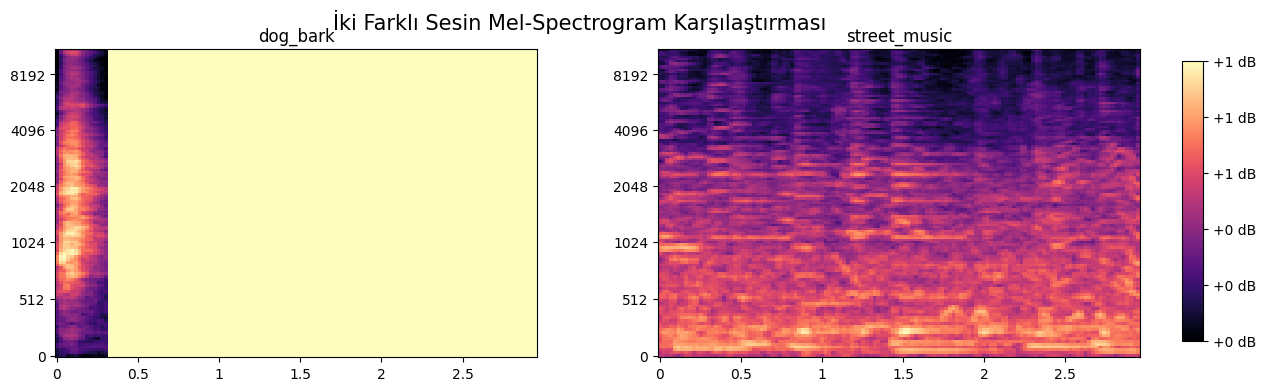

In [ ]:
classes_to_show = ["dog_bark", "street_music"]

fig, axes = plt.subplots(1, 2, figsize=(14, 4))  
plt.subplots_adjust(wspace=0.25)  

for i, cls in enumerate(classes_to_show):
    row = df[df["class"] == cls].iloc[0]
    fold = row['fold']
    fname = row['slice_file_name']
    file_path = os.path.join(AUDIO_PATH, f"fold{fold}", fname)

    spec = extract_mel_spectrogram(file_path)

    img = librosa.display.specshow(
        spec.squeeze(),
        sr=22050,
        x_axis='time',
        y_axis='mel',
        ax=axes[i]
    )

    axes[i].set_title(cls)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

# Colorbar
cbar_ax = fig.add_axes([0.93, 0.15, 0.015, 0.7])
fig.colorbar(img, cax=cbar_ax, format="%+2.0f dB")

fig.suptitle("İki Farklı Sesin Mel-Spectrogram Karşılaştırması", fontsize=15)
plt.show()


## 4. Dataset'in Hazırlanması (X, y)

Bu adımda her WAV dosyası Mel-Spectrogram'a dönüştürülerek
modelde kullanılacak giriş verisi (`X`) ve etiketler (`y`) oluşturulur.

RAM ve işlem süresini optimize etmek için her sınıftan en fazla
**80 örnek** kullandık. (Sonradan artırılabilir.)


In [ ]:
MAX_FILES_PER_CLASS = 80   

X = []
y = []
class_counts = {}

for idx, row in df.iterrows():
    fold = row["fold"]
    fname = row["slice_file_name"]
    label = row["class"]
    class_id = row["classID"]

    
    if label not in class_counts:
        class_counts[label] = 0
    if class_counts[label] >= MAX_FILES_PER_CLASS:
        continue

    file_path = os.path.join(AUDIO_PATH, f"fold{fold}", fname)

    try:
        
        spec = extract_mel_spectrogram(file_path)

        
        X.append(spec)
        y.append(class_id)

        
        class_counts[label] += 1

    except Exception as e:
        print("Hata:", e, "→ Dosya:", file_path)


X = np.array(X)
y = np.array(y)

print("X shape:", X.shape)
print("y shape:", y.shape)
print("Her sınıftan alınan örnek sayısı:", class_counts)


X shape: (800, 128, 128, 1)
y shape: (800,)
Her sınıftan alınan örnek sayısı: {'dog_bark': 80, 'children_playing': 80, 'car_horn': 80, 'air_conditioner': 80, 'street_music': 80, 'gun_shot': 80, 'siren': 80, 'engine_idling': 80, 'jackhammer': 80, 'drilling': 80}


## 5. Train / Test Split

Veriyi eğitim ve test olmak üzere ikiye ayırıyoruz.
Eğitim: %80
Test: %20

`stratify=y` parametresi, sınıf dağılımının dengeli kalmasını sağlar.


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train:", X_train.shape, y_train.shape)
print("Test :", X_test.shape, y_test.shape)


Train: (640, 128, 128, 1) (640,)
Test : (160, 128, 128, 1) (160,)


## 6. CNN Modelinin Tanımlanması

Bu bölümde 3 konvolüsyon bloğundan oluşan basit bir CNN modeli
tanımlanmaktadır:

- Conv2D(32) + MaxPool
- Conv2D(64) + MaxPool
- Conv2D(128) + MaxPool
- Flatten + Dense(128) + Dropout(0.5)
- Çıkış: 10 sınıflı Softmax

Kayıp fonksiyonu: `sparse_categorical_crossentropy`  
Optimizasyon: `Adam`


In [ ]:
input_shape = X_train.shape[1:]      # (128, 128, 1)
num_classes = len(np.unique(y))      # 10 sınıf

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,288,394 (16.36 MB)

 Trainable params: 4,288,394 (16.36 MB)

 Non-trainable params: 0 (0.00 B)

## 7. Modelin Eğitilmesi

Model 20 epoch boyunca eğitilmektedir.
Verinin %20'si eğitim sırasında doğrulama (validation) için ayrılmıştır.


In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)


Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.0855 - loss: 2.3721 - val_accuracy: 0.2891 - val_loss: 2.2419
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.1995 - loss: 2.1731 - val_accuracy: 0.4062 - val_loss: 1.9148
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.3636 - loss: 1.8549 - val_accuracy: 0.5703 - val_loss: 1.6302
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.4329 - loss: 1.6518 - val_accuracy: 0.7109 - val_loss: 1.1627
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.5624 - loss: 1.3525 - val_accuracy: 0.7188 - val_loss: 0.8393
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.6461 - loss: 1.1111 - val_accuracy: 0.8047 - val_loss: 0.6719
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.6994 - loss: 0.9036 - val_accuracy: 0.7969 - val_loss: 0.6238
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.7364 - loss: 0.8718 - val_accuracy: 0.8438 - val_loss:

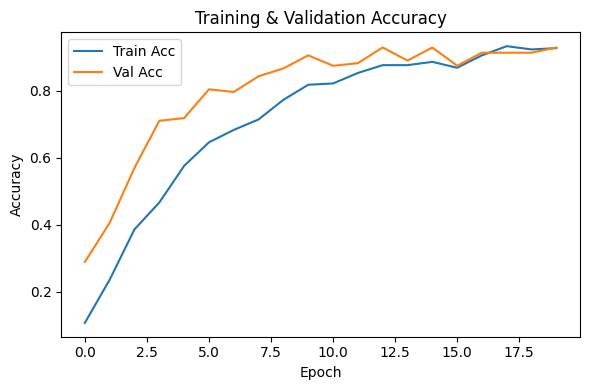

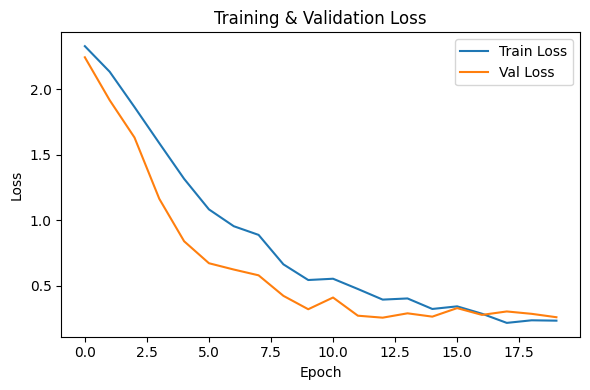

In [ ]:
# Accuracy grafiği
plt.figure(figsize=(6,4))
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

# Loss grafiği
plt.figure(figsize=(6,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.tight_layout()
plt.show()


Test Loss : 0.6795941591262817
Test Acc  : 0.8812500238418579
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 291ms/step


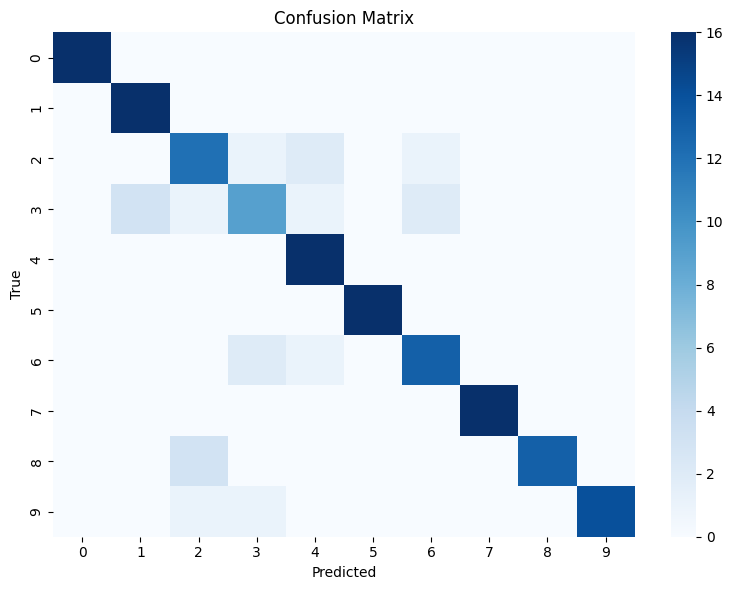


Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       0.84      1.00      0.91        16
           2       0.71      0.75      0.73        16
           3       0.69      0.56      0.62        16
           4       0.80      1.00      0.89        16
           5       1.00      1.00      1.00        16
           6       0.81      0.81      0.81        16
           7       1.00      1.00      1.00        16
           8       1.00      0.81      0.90        16
           9       1.00      0.88      0.93        16

    accuracy                           0.88       160
   macro avg       0.89      0.88      0.88       160
weighted avg       0.89      0.88      0.88       160



In [ ]:
# Test set performansı
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print("Test Loss :", test_loss)
print("Test Acc  :", test_acc)

# Tahminler
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))


In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print("Test Accuracy:", test_acc)
print("Test Loss:", test_loss)


Test Accuracy: 0.8812500238418579
Test Loss: 0.6795941591262817
